# ResNet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset download

In [2]:
import urllib.request
import tarfile

# Dataset URL
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"

# Download destination path
file_name = "flower_photos.tgz"

# File download
urllib.request.urlretrieve(url, file_name)

# File extraction
tar = tarfile.open(file_name)
tar.extractall()
tar.close()

Dataset split into train (0.7), validation (0.2) and test set (0.1)

In [3]:
!pip install split-folders
import splitfolders
splitfolders.ratio('flower_photos', output="output", seed=1337, ratio=(0.7, 0.2, 0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3670 files [00:00, 4803.96 files/s]


Libraries import

In [4]:
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import numpy as np

import random as python_random

from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

Set the seeds

In [5]:
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

Path for train, validation and test set

In [6]:
path_train='/content/output/train/'
path_val='/content/output/val/'
path_test='/content/output/test/'



Saving train, validation and test set

In [7]:
train_dataset = keras.preprocessing.image_dataset_from_directory(path_train,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=True,
                                                            seed=1)

val_dataset = keras.preprocessing.image_dataset_from_directory(path_val,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=True,
                                                            seed=1)

test_dataset = keras.preprocessing.image_dataset_from_directory(path_test,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=True,
                                                            seed=1)

Found 2567 files belonging to 5 classes.
Found 731 files belonging to 5 classes.
Found 372 files belonging to 5 classes.


In [8]:
class_names = train_dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Data augmentation

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [10]:
num_classes=5

We start by training the model with:
-fixed value of number of dense nodes and regularizer and variable learning rate

# Net with optimizer Adam and variable learning rate
- dense nodes= 512
- regularizer = 0.001

In [11]:
# learning rate values
lr_values = [0.01, 0.001, 0.0001]


histories_Adam_lr = []
evaluate_test = []

for lr in lr_values:
    # Create the model
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    for layer in resnet_model.layers:
        layer.trainable = False

    from keras import regularizers

    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    x = data_augmentation(x)
    x = keras.applications.resnet.preprocess_input(x)
    x = resnet_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    net_Adam_lr = keras.Model(inputs=inputs, outputs=outputs)

    from tensorflow.keras.optimizers import Adam
    # Compile the model
    net_Adam_lr.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

    net_Adam_lr.summary()

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # train the model
    history_Adam_lr = net_Adam_lr.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

    evaluate = loss, accuracy = net_Adam_lr.evaluate(test_dataset)

    evaluate_test.append(evaluate)

    net_Adam_lr.save('gdrive/MyDrive/FDL/resnet_Adam_lr_{}.h5'.format(lr))

    histories_Adam_lr.append(history_Adam_lr)



94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0      

In [12]:
evaluate_test

[[0.8817784190177917, 0.9193548560142517],
 [0.5992822051048279, 0.9274193644523621],
 [0.7814629077911377, 0.9166666865348816]]

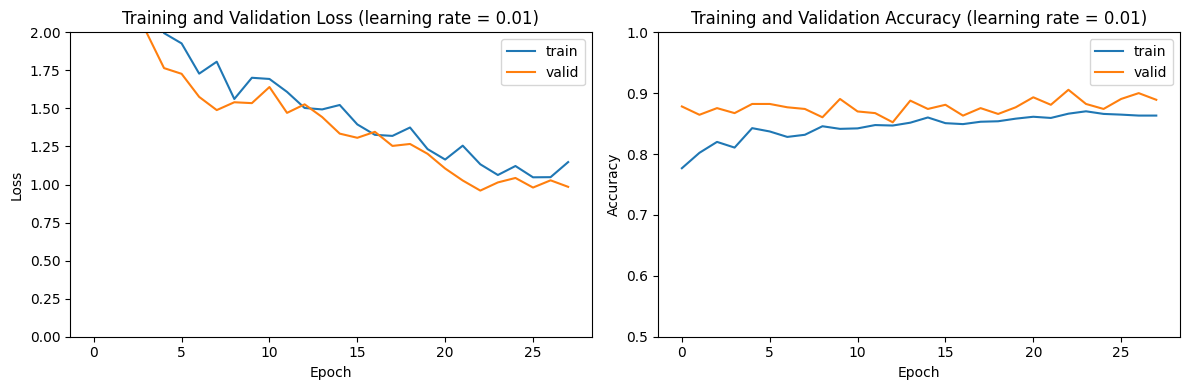

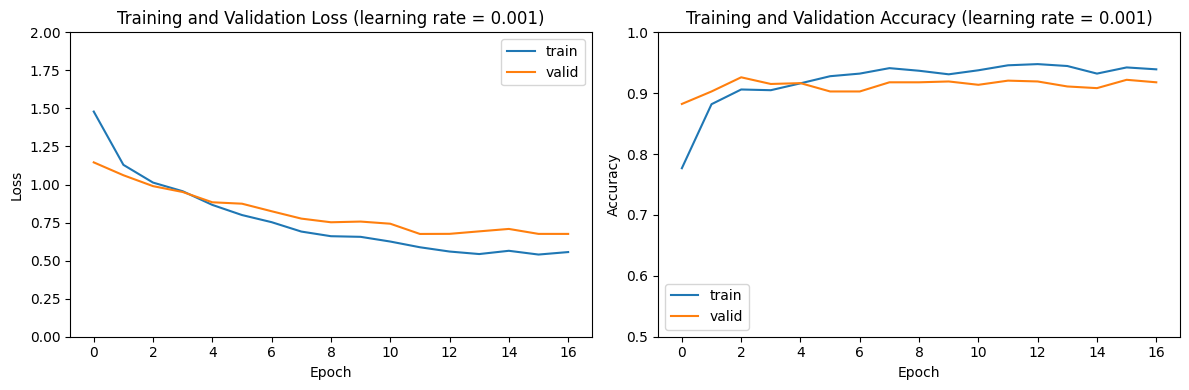

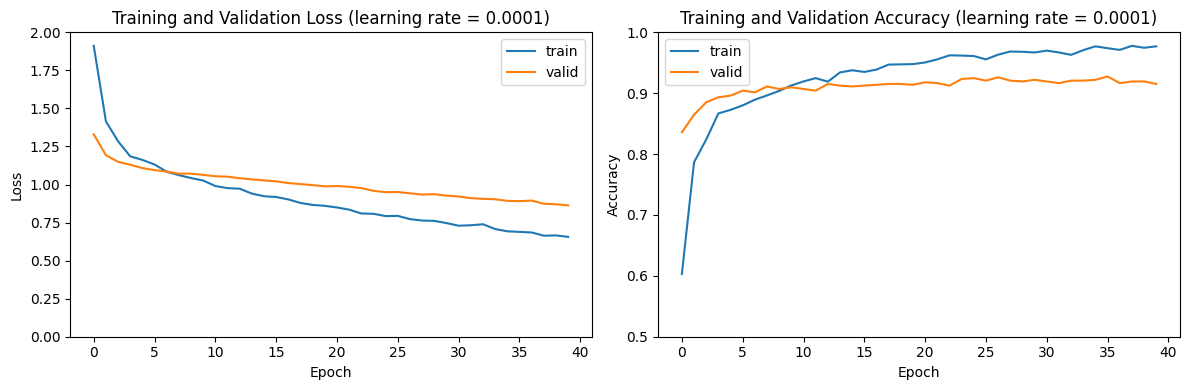

 Learning Rate  Loss Diff Mean  Accuracy Diff Mean
        0.0100          0.1588              0.0328
        0.0010          0.1023              0.0260
        0.0001          0.1436              0.0411


In [13]:
import pandas as pd


table_data = {'Learning Rate': lr_values, 'Loss Diff Mean': [], 'Accuracy Diff Mean': []}

for i, history in enumerate(histories_Adam_lr):
    lr = lr_values[i]

    train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)


    train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)


    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Loss (learning rate = {lr})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (learning rate = {lr})');

    plt.tight_layout()
    plt.show()


table_df = pd.DataFrame(table_data)


print(table_df.to_string(index=False, float_format='%.4f'))


# Net with optimizer RMS and variable learning rate
- dense nodes = 512
- regularizer = 0.001

In [14]:
# learning rate values
lr_values = [0.01, 0.001, 0.0001]


histories_RMS_lr = []
evaluate_test = []

for lr in lr_values:
    # Create the model
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    for layer in resnet_model.layers:
        layer.trainable = False

    from keras import regularizers

    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    x = data_augmentation(x)
    x = keras.applications.resnet.preprocess_input(x)
    x = resnet_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    net_RMS_lr = keras.Model(inputs=inputs, outputs=outputs)


    # Compile the model
    net_RMS_lr.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy'])

    net_RMS_lr.summary()

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # train the model
    history_RMS_lr = net_RMS_lr.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

    evaluate = loss, accuracy = net_RMS_lr.evaluate(test_dataset)
    evaluate_test.append(evaluate)

    net_RMS_lr.save('drive/MyDrive/FDL/resnet_RMS_lr_{}.h5'.format(lr))

    histories_RMS_lr.append(history_RMS_lr)



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

In [15]:
evaluate_test

[[0.610940158367157, 0.9086021780967712],
 [0.48097705841064453, 0.9139785170555115],
 [0.6510272026062012, 0.9381720423698425]]

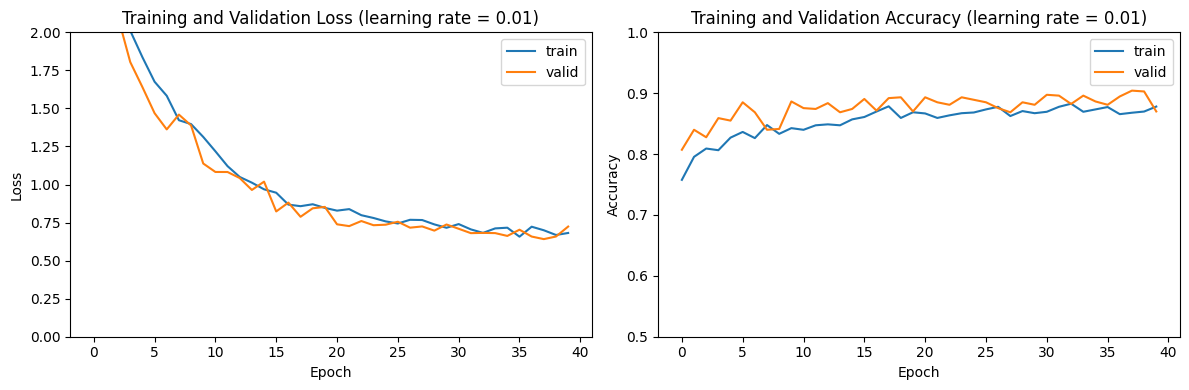

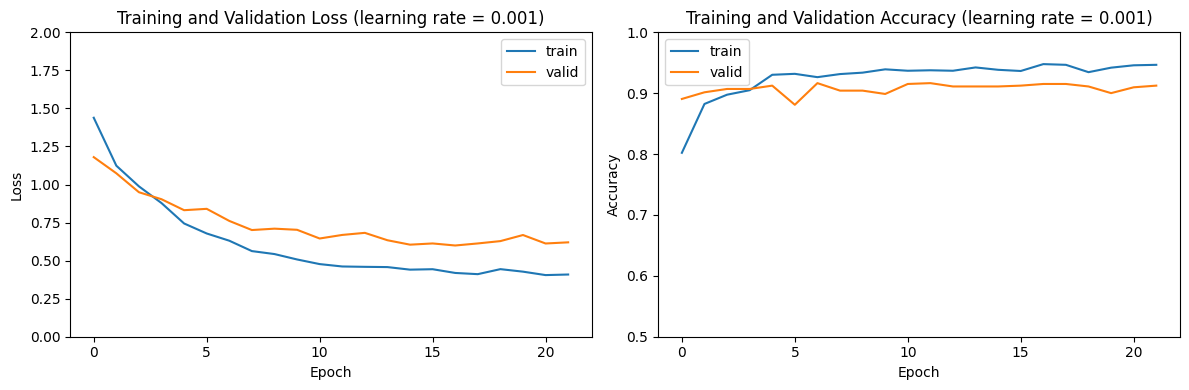

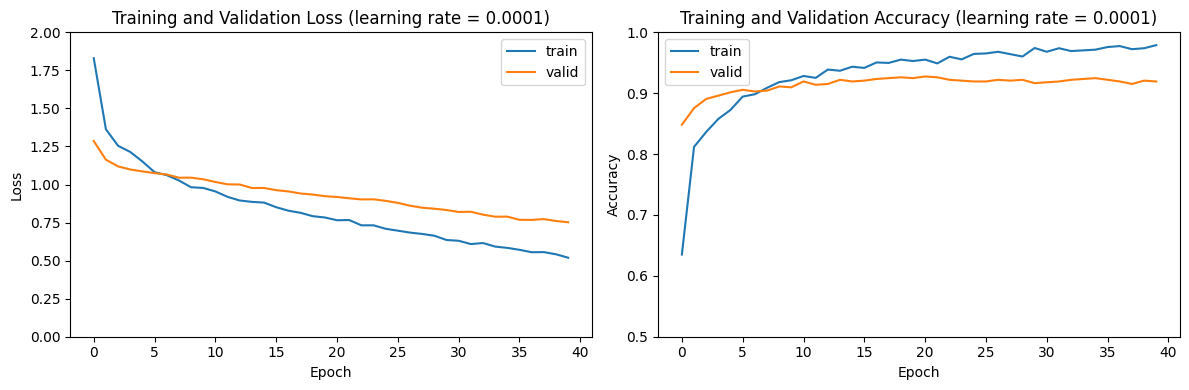

 Learning Rate  Loss Diff Mean  Accuracy Diff Mean
        0.0100          0.0667              0.0230
        0.0010          0.1630              0.0294
        0.0001          0.1522              0.0395


In [16]:
import pandas as pd


table_data = {'Learning Rate': lr_values, 'Loss Diff Mean': [], 'Accuracy Diff Mean': []}

for i, history in enumerate(histories_RMS_lr):
    lr = lr_values[i]

    train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)


    train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)



    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Loss (learning rate = {lr})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (learning rate = {lr})');

    plt.tight_layout()
    plt.show()



table_df = pd.DataFrame(table_data)


print(table_df.to_string(index=False, float_format='%.4f'))


# Adam vs RMSprop graphs with different learning rate values

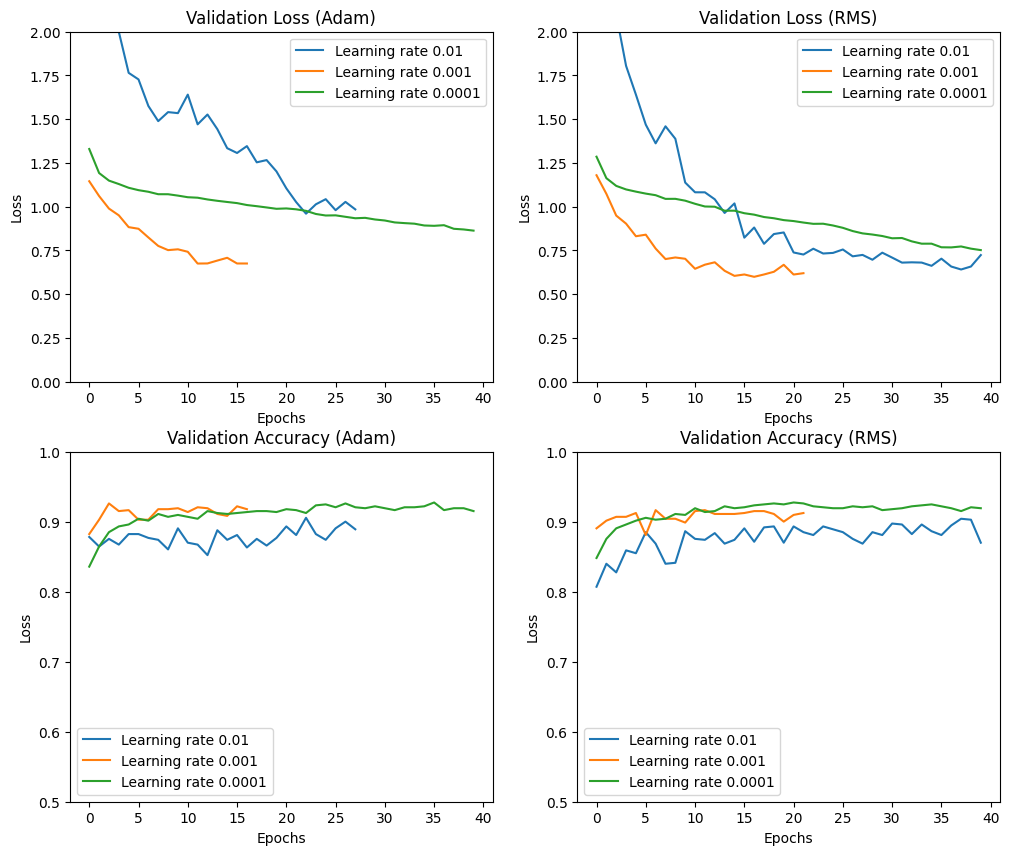

In [17]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)

for i, history in enumerate(histories_Adam_lr):
    plt.plot(history.history['val_loss'], label='Learning rate {}'.format(lr_values[i]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss (Adam)')
plt.legend()



plt.subplot(2, 2, 2)
for i, history in enumerate(histories_RMS_lr):
    plt.plot(history.history['val_loss'], label='Learning rate {}'.format(lr_values[i]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss (RMS)')
plt.legend()



plt.subplot(2, 2, 3)
for i, history in enumerate(histories_Adam_lr):
    plt.plot(history.history['val_accuracy'], label='Learning rate {}'.format(lr_values[i]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy (Adam)')
plt.legend()



plt.subplot(2, 2, 4)
for i, history in enumerate(histories_RMS_lr):
    plt.plot(history.history['val_accuracy'], label='Learning rate {}'.format(lr_values[i]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy (RMS)')
plt.legend()


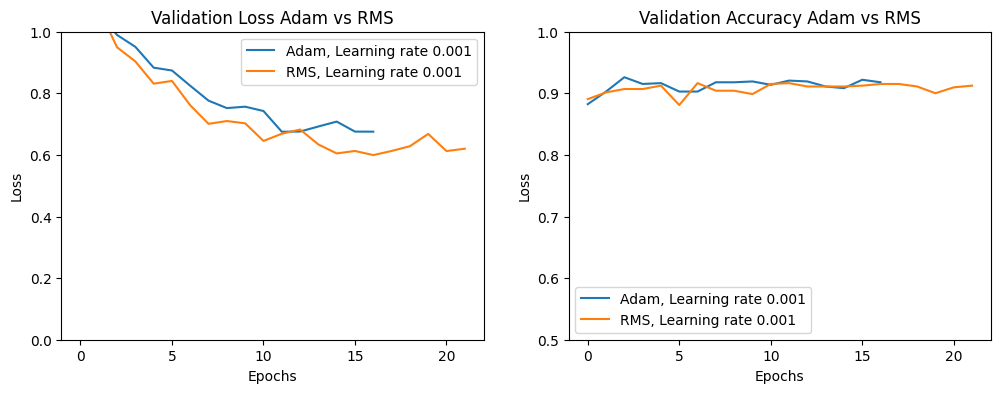

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(histories_Adam_lr[1].history['val_loss'], label='Adam, Learning rate {}'.format(lr_values[1]))
plt.plot(histories_RMS_lr[1].history['val_loss'], label='RMS, Learning rate {}'.format(lr_values[1]))
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Adam vs RMS')
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(histories_Adam_lr[1].history['val_accuracy'], label='Adam, Learning rate {}'.format(lr_values[1]))
plt.plot(histories_RMS_lr[1].history['val_accuracy'], label='RMS, Learning rate {}'.format(lr_values[1]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy Adam vs RMS')
plt.legend()




Now we fix the learning rate value to 0.001 that is the one that gave us the best model

# Net with optimizer Adam and variable regularizer
- learning rate = 0.001
- dense nodes = 512

In [19]:
# regularizer values
reg_values = [0.1, 0.01, 0.001, 0.0001]


histories_Adam_reg = []
evaluate_test = []

for reg in reg_values:
    # Create the model
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    for layer in resnet_model.layers:
        layer.trainable = False

    from keras import regularizers

    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    x = data_augmentation(x)
    x = keras.applications.resnet.preprocess_input(x)
    x = resnet_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    net_Adam_reg = keras.Model(inputs=inputs, outputs=outputs)

    from tensorflow.keras.optimizers import Adam
    # Compile the model
    net_Adam_reg.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


    net_Adam_reg.summary()


    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # train the model
    history_Adam_reg = net_Adam_reg.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

    evaluate = loss, accuracy = net_Adam_reg.evaluate(test_dataset)
    evaluate_test.append(evaluate)

    net_Adam_reg.save('drive/MyDrive/FDL/resnet_Adam_reg_{}.h5'.format(reg))

    histories_Adam_reg.append(history_Adam_reg)



Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_6   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0   

In [20]:
evaluate_test

[[1.6367380619049072, 0.8763440847396851],
 [0.9806309342384338, 0.9112903475761414],
 [0.5872626900672913, 0.948924720287323],
 [0.31873488426208496, 0.9274193644523621]]

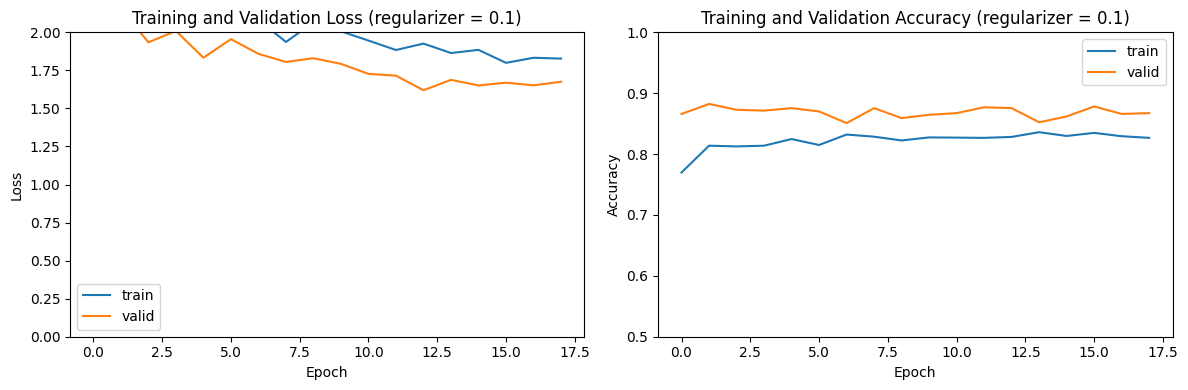

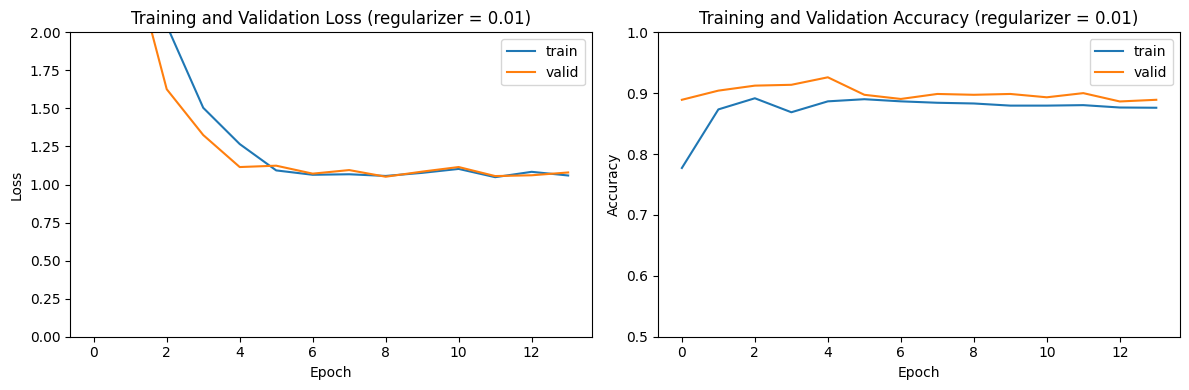

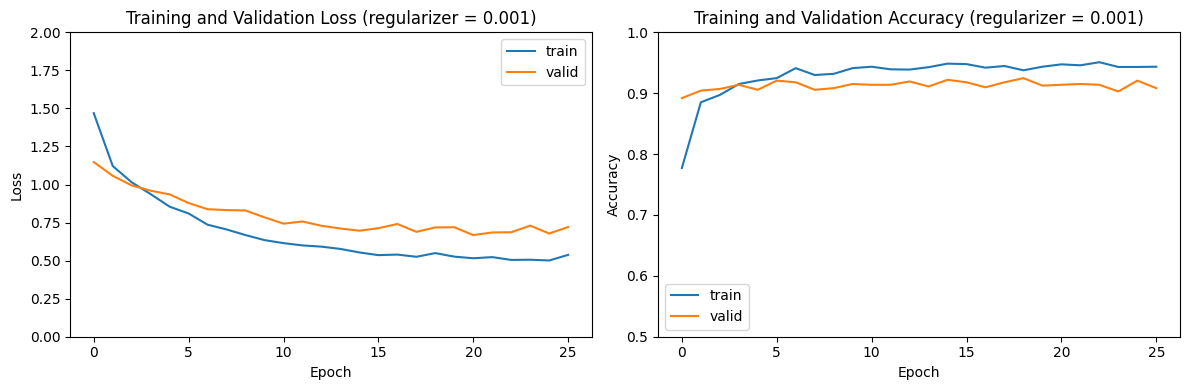

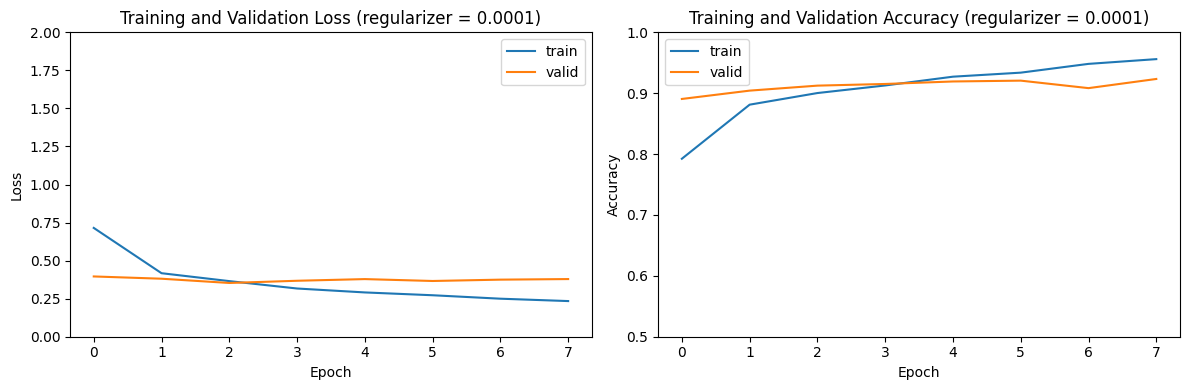

 Regularizer  Loss Diff Mean  Accuracy Diff Mean
      0.1000          1.3281              0.0464
      0.0100          0.2963              0.0260
      0.0010          0.1462              0.0279
      0.0001          0.1087              0.0287


In [21]:
import pandas as pd


table_data = {'Regularizer': reg_values, 'Loss Diff Mean': [], 'Accuracy Diff Mean': []}

for i, history in enumerate(histories_Adam_reg):
    reg = reg_values[i]

    train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)


    train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)



    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Loss (regularizer = {reg})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (regularizer = {reg})');

    plt.tight_layout()
    plt.show()


table_df = pd.DataFrame(table_data)


print(table_df.to_string(index=False, float_format='%.4f'))


# Net with optimizer RMS and variable regularizer
- learning rate = 0.001
- dense nodes = 512

In [22]:
# regularizer values
reg_values = [0.1, 0.01, 0.001, 0.0001]


histories_RMS_reg = []
evaluate_test = []

for reg in reg_values:
    # Create the model
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    for layer in resnet_model.layers:
        layer.trainable = False

    from keras import regularizers

    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    x = data_augmentation(x)
    x = keras.applications.resnet.preprocess_input(x)
    x = resnet_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(reg))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    net_RMS_reg = keras.Model(inputs=inputs, outputs=outputs)


    # Compile the model
    net_RMS_reg.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

    net_RMS_reg.summary()

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # train the model
    history_RMS_reg = net_RMS_reg.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

    evaluate = loss, accuracy = net_RMS_reg.evaluate(test_dataset)
    evaluate_test.append(evaluate)

    net_RMS_reg.save('drive/MyDrive/FDL/resnet_RMS_reg_{}.h5'.format(reg))

    histories_RMS_reg.append(history_RMS_reg)



Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_10  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_10 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0  

In [23]:
evaluate_test

[[1.367870569229126, 0.8897849321365356],
 [0.8013567328453064, 0.9086021780967712],
 [0.5157936811447144, 0.9193548560142517],
 [0.3112984299659729, 0.9327957034111023]]

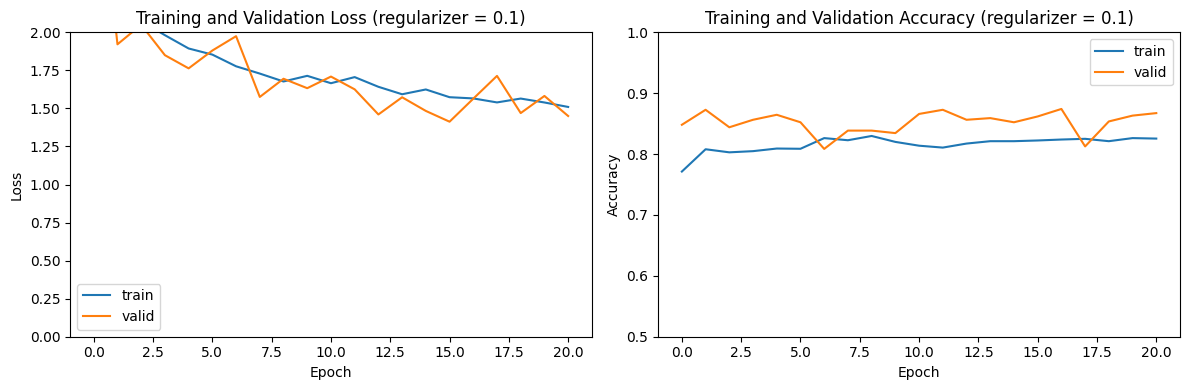

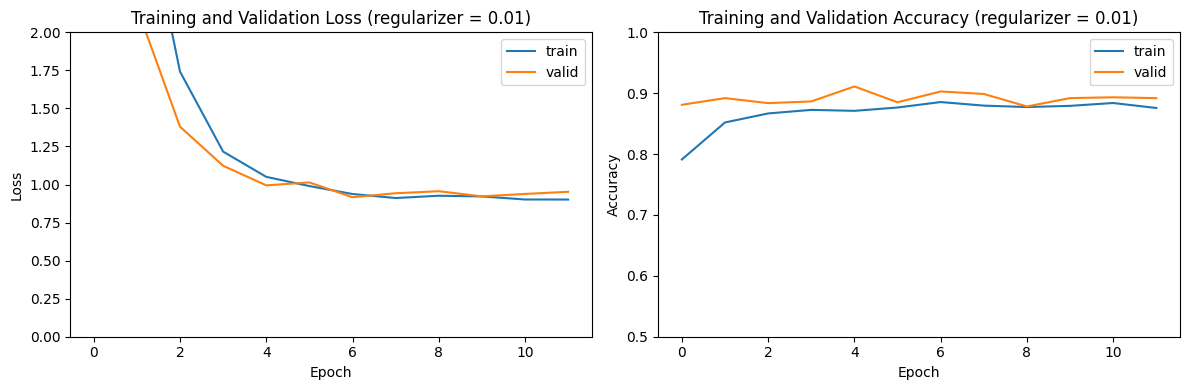

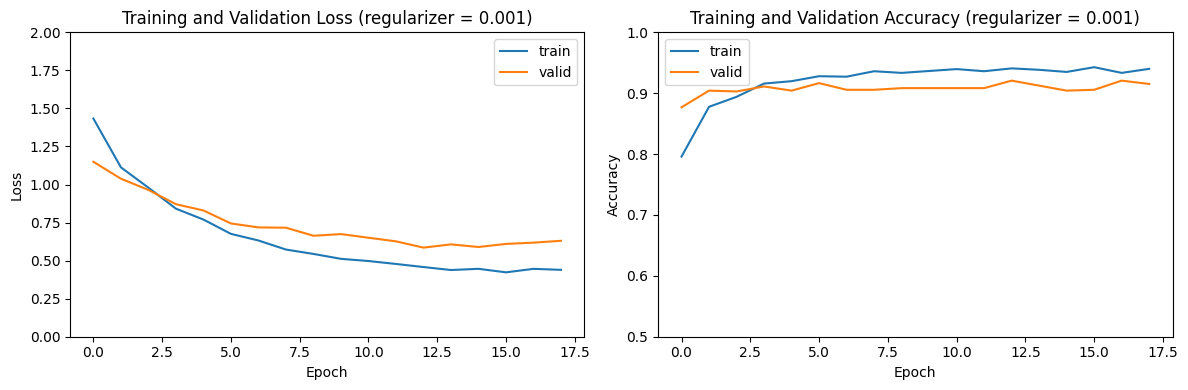

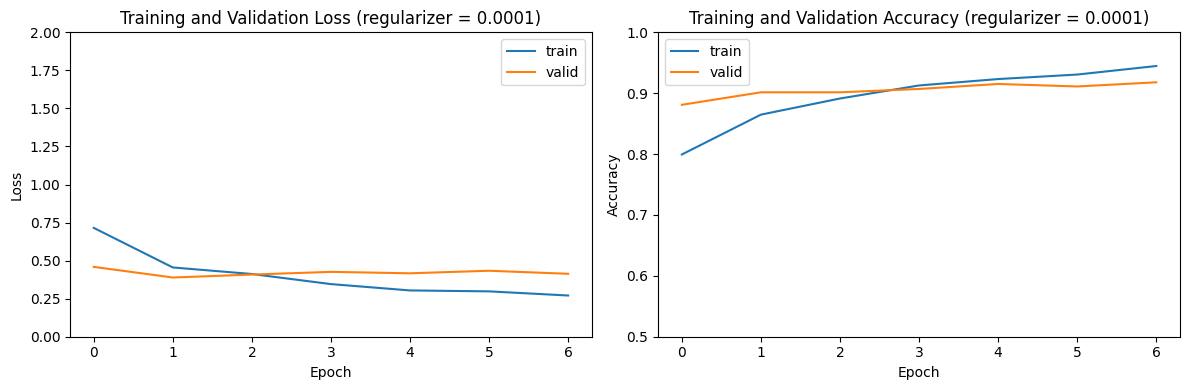

 Regularizer  Loss Diff Mean  Accuracy Diff Mean
      0.1000          0.8455              0.0393
      0.0100          0.3238              0.0237
      0.0010          0.1296              0.0258
      0.0001          0.1139              0.0270


In [24]:
import pandas as pd


table_data = {'Regularizer': reg_values, 'Loss Diff Mean': [], 'Accuracy Diff Mean': []}

for i, history in enumerate(histories_RMS_reg):
    reg = reg_values[i]

    train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)

    train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)


    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid' ])
    plt.title(f'Training and Validation Loss (regularizer = {reg})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (regularizer = {reg})');

    plt.tight_layout()
    plt.show()


table_df = pd.DataFrame(table_data)


print(table_df.to_string(index=False, float_format='%.4f'))


# Adam vs RMSprop graphs with different regularizer values

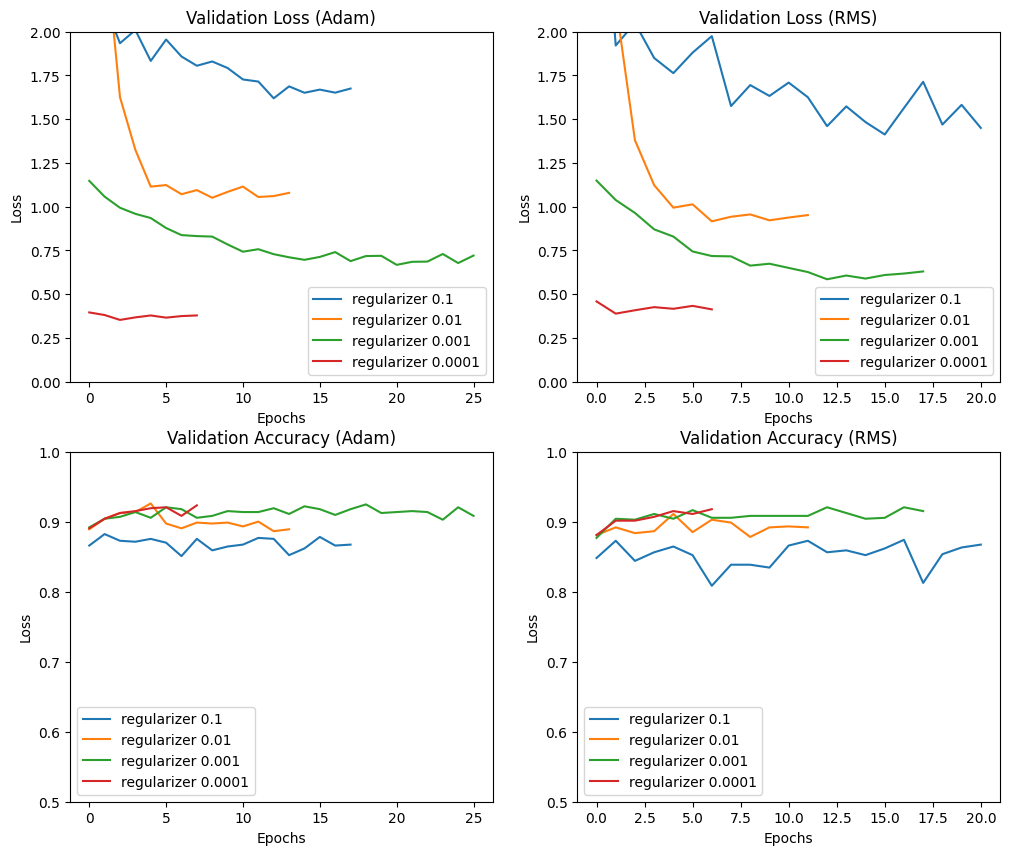

In [25]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)

for i, history in enumerate(histories_Adam_reg):
    plt.plot(history.history['val_loss'], label='regularizer {}'.format(reg_values[i]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss (Adam)')
plt.legend()



plt.subplot(2, 2, 2)
for i, history in enumerate(histories_RMS_reg):
    plt.plot(history.history['val_loss'], label='regularizer {}'.format(reg_values[i]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss (RMS)')
plt.legend()



plt.subplot(2, 2, 3)
for i, history in enumerate(histories_Adam_reg):
    plt.plot(history.history['val_accuracy'], label='regularizer {}'.format(reg_values[i]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy (Adam)')
plt.legend()



plt.subplot(2, 2, 4)
for i, history in enumerate(histories_RMS_reg):
    plt.plot(history.history['val_accuracy'], label='regularizer {}'.format(reg_values[i]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy (RMS)')
plt.legend()


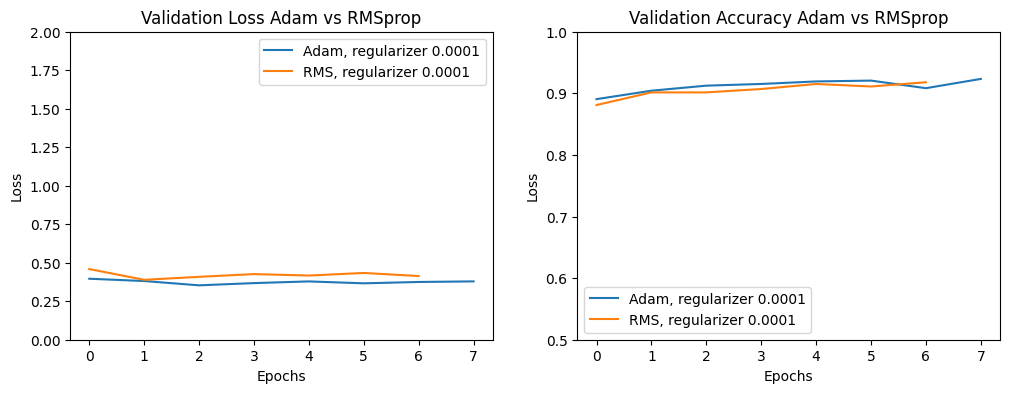

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(histories_Adam_reg[3].history['val_loss'], label='Adam, regularizer {}'.format(reg_values[3]))
plt.plot(histories_RMS_reg[3].history['val_loss'], label='RMS, regularizer {}'.format(reg_values[3]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Adam vs RMSprop')
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(histories_Adam_reg[3].history['val_accuracy'], label='Adam, regularizer {}'.format(reg_values[3]))
plt.plot(histories_RMS_reg[3].history['val_accuracy'], label='RMS, regularizer {}'.format(reg_values[3]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy Adam vs RMSprop')
plt.legend()


Now we fix the regularizer value to 0.0001, that is the one that give us the best result

# Net with optimizer Adam and variable number of dense nodes
- learning rate = 0.001
- regularizer = 0.0001

In [27]:
# number of dense nodes
num_dense = [64, 128, 512]


histories_Adam_dense = []
evaluate_test = []

for dense in num_dense:
    # Create the model
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    for layer in resnet_model.layers:
        layer.trainable = False

    from keras import regularizers

    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    x = data_augmentation(x)
    x = keras.applications.resnet.preprocess_input(x)
    x = resnet_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(dense, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    net_Adam_dense = keras.Model(inputs=inputs, outputs=outputs)

    from tensorflow.keras.optimizers import Adam
    # Compile the model
    net_Adam_dense.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

    net_Adam_dense.summary()

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # train the model
    history_Adam_dense = net_Adam_dense.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

    loss, accuracy = net_Adam_dense.evaluate(test_dataset)
    evaluate_test.append(evaluate)

    net_Adam_dense.save('drive/MyDrive/FDL/resnet_Adam_dense_{}.h5'.format(dense))

    histories_Adam_dense.append(history_Adam_dense)



Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_14  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_14 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_14  (None, 2048)             0  

In [28]:
evaluate_test

[[0.3112984299659729, 0.9327957034111023],
 [0.3112984299659729, 0.9327957034111023],
 [0.3112984299659729, 0.9327957034111023]]

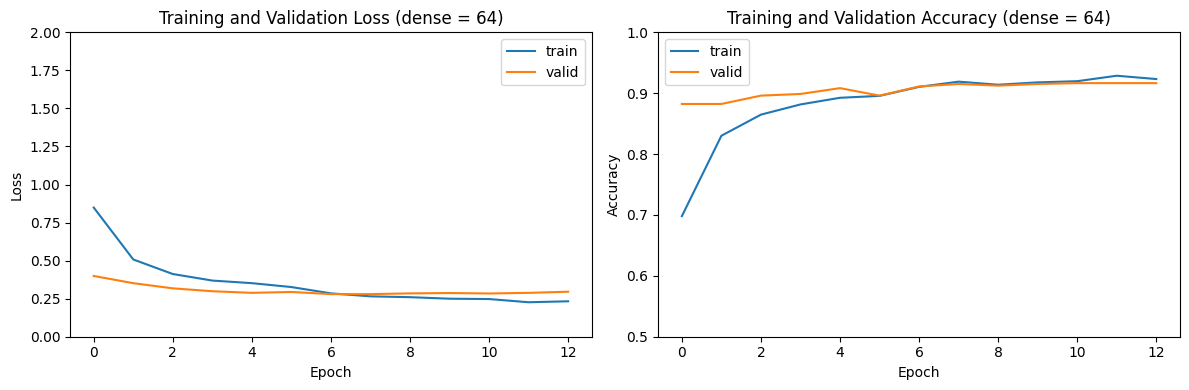

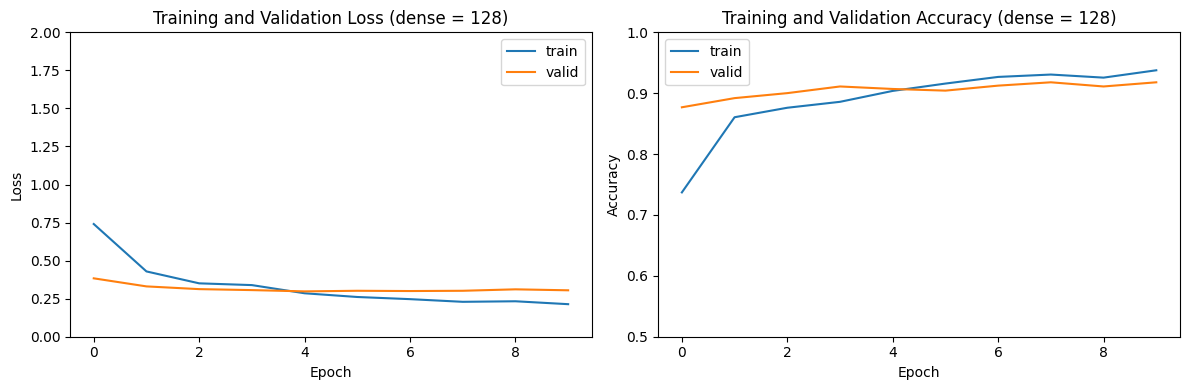

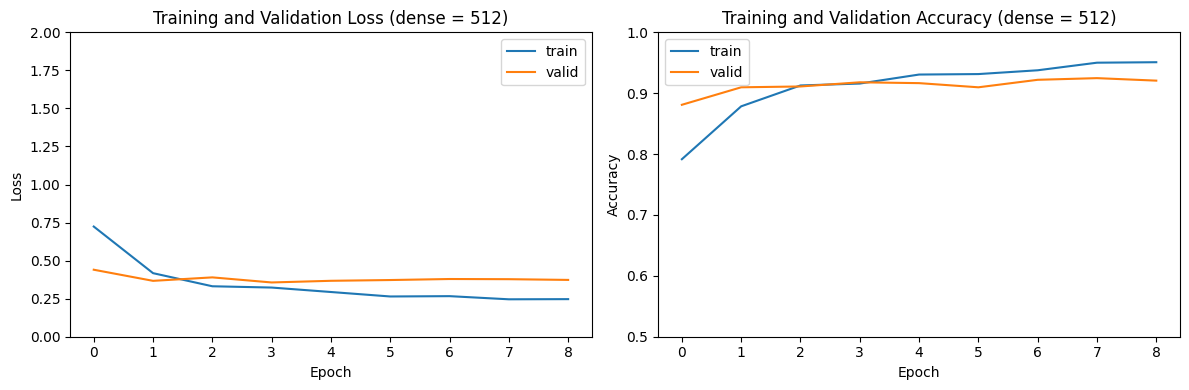

 Dense  Loss Diff Mean  Accuracy Diff Mean
    64          0.0853              0.0255
   128          0.0875              0.0297
   512          0.1088              0.0257


In [29]:
import pandas as pd


table_data = {'Dense': num_dense, 'Loss Diff Mean': [], 'Accuracy Diff Mean': []}

for i, history in enumerate(histories_Adam_dense):
    dense = num_dense[i]

    train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)

    train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)


    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid' ])
    plt.title(f'Training and Validation Loss (dense = {dense})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (dense = {dense})');

    plt.tight_layout()
    plt.show()


table_df = pd.DataFrame(table_data)


print(table_df.to_string(index=False, float_format='%.4f'))


# Net with optimizer RMS and variable number of dense nodes
- learning rate = 0.001
- regularizer = 0.0001

In [30]:
# number of dense nodes
num_dense = [64, 128, 512]


histories_RMS_dense = []
evaluate_test = []

for dense in num_dense:
    # Create the model
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    for layer in resnet_model.layers:
        layer.trainable = False

    from keras import regularizers

    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    x = data_augmentation(x)
    x = keras.applications.resnet.preprocess_input(x)
    x = resnet_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(dense, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    net_RMS_dense = keras.Model(inputs=inputs, outputs=outputs)


    # Compile the model
    net_RMS_dense.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

    net_RMS_dense.summary()

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # train the model
    history_RMS_dense = net_RMS_dense.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

    evaluate = loss, accuracy = net_RMS_dense.evaluate(test_dataset)
    evaluate_test.append(evaluate)

    net_RMS_dense.save('drive/MyDrive/FDL/resnet_RMS_dense_{}.h5'.format(dense))

    histories_RMS_dense.append(history_RMS_dense)



Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_17  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_17 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0  

In [31]:
evaluate_test

[[0.23703527450561523, 0.9193548560142517],
 [0.2463705837726593, 0.9220430254936218],
 [0.31807637214660645, 0.9193548560142517]]

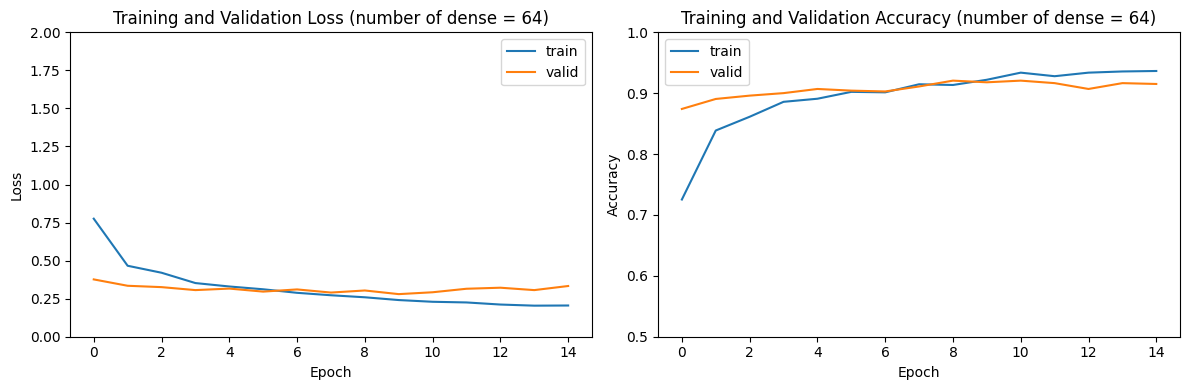

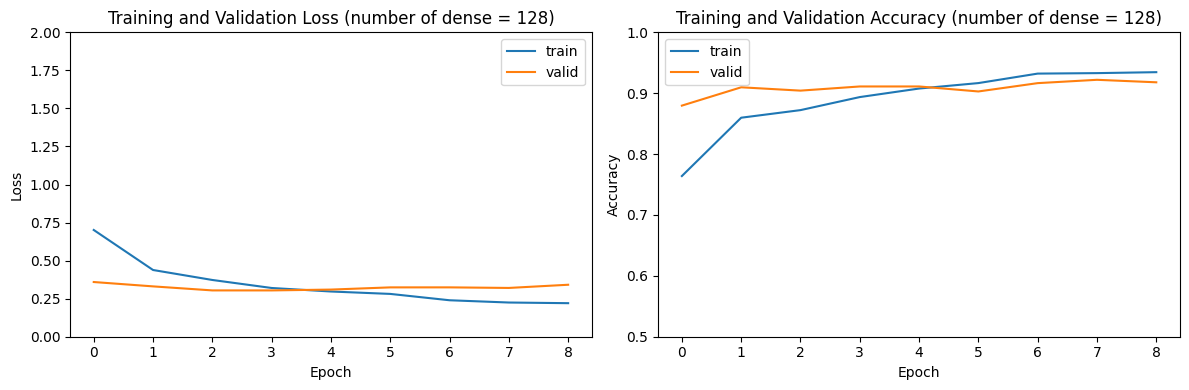

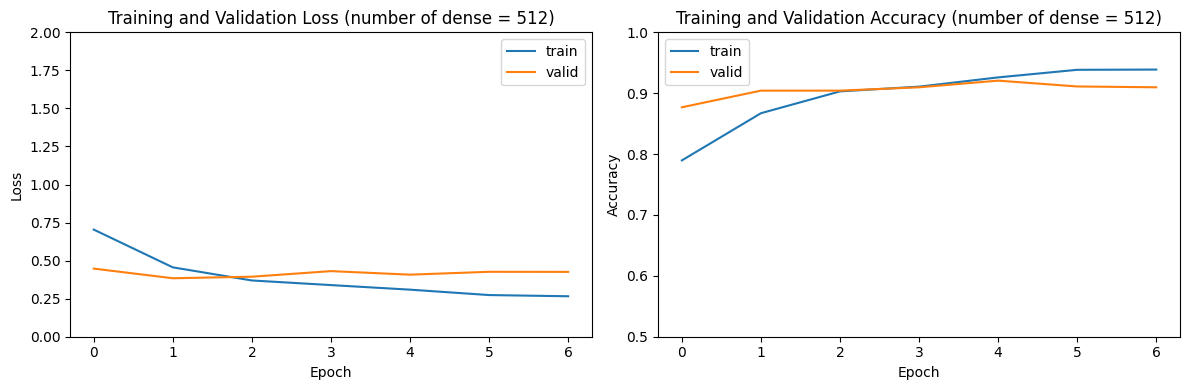

 Dense  Loss Diff Mean  Accuracy Diff Mean
    64          0.0878              0.0251
   128          0.0990              0.0306
   512          0.1223              0.0269


In [32]:
import pandas as pd


table_data = {'Dense': num_dense, 'Loss Diff Mean': [], 'Accuracy Diff Mean': []}

for i, history in enumerate(histories_RMS_dense):
    dense = num_dense[i]

    train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)
    avg_loss_diff_text = f'Loss Diff: {avg_loss_diff:.4f}'

    train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)
    avg_acc_diff_text = f'Accuracy Diff: {avg_acc_diff:.4f}'


    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Loss (number of dense = {dense})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (number of dense = {dense})');

    plt.tight_layout()
    plt.show()


table_df = pd.DataFrame(table_data)


print(table_df.to_string(index=False, float_format='%.4f'))


# Adam vs RMSprop graphs with different number of dense nodes

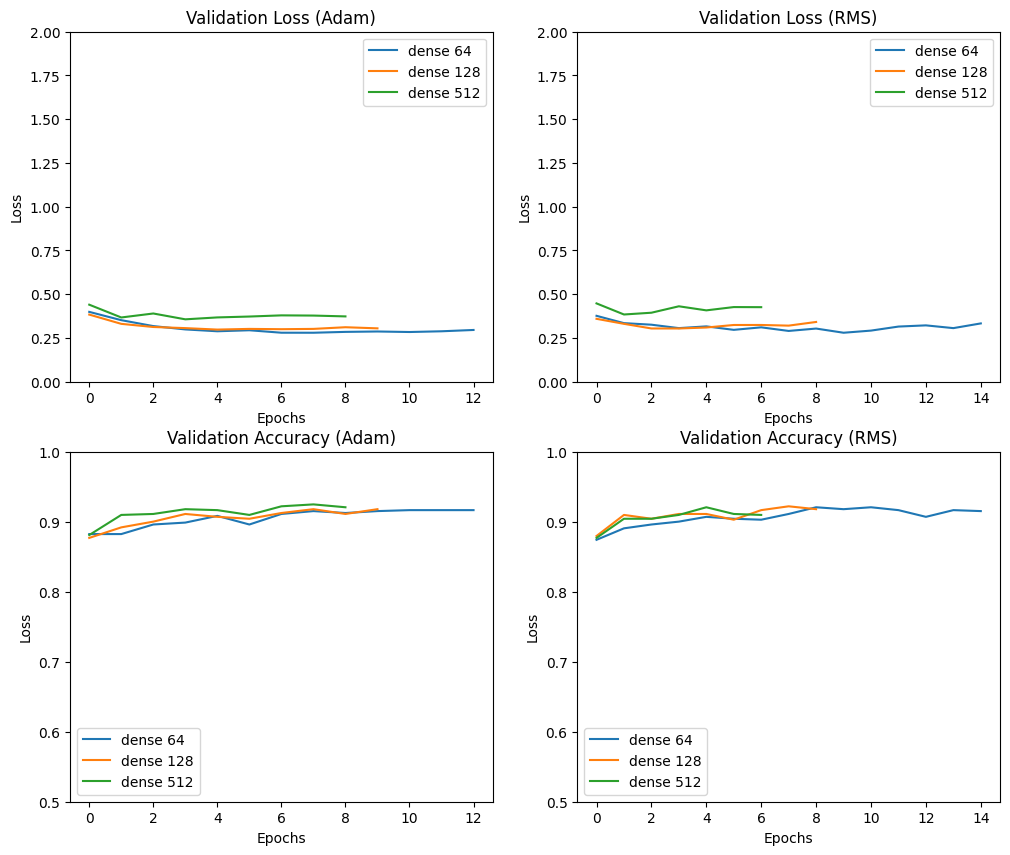

In [33]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)

for i, history in enumerate(histories_Adam_dense):
    plt.plot(history.history['val_loss'], label='dense {}'.format(num_dense[i]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss (Adam)')
plt.legend()



plt.subplot(2, 2, 2)
for i, history in enumerate(histories_RMS_dense):
    plt.plot(history.history['val_loss'], label='dense {}'.format(num_dense[i]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss (RMS)')
plt.legend()



plt.subplot(2, 2, 3)
for i, history in enumerate(histories_Adam_dense):
    plt.plot(history.history['val_accuracy'], label='dense {}'.format(num_dense[i]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy (Adam)')
plt.legend()



plt.subplot(2, 2, 4)
for i, history in enumerate(histories_RMS_dense):
    plt.plot(history.history['val_accuracy'], label='dense {}'.format(num_dense[i]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy (RMS)')
plt.legend()


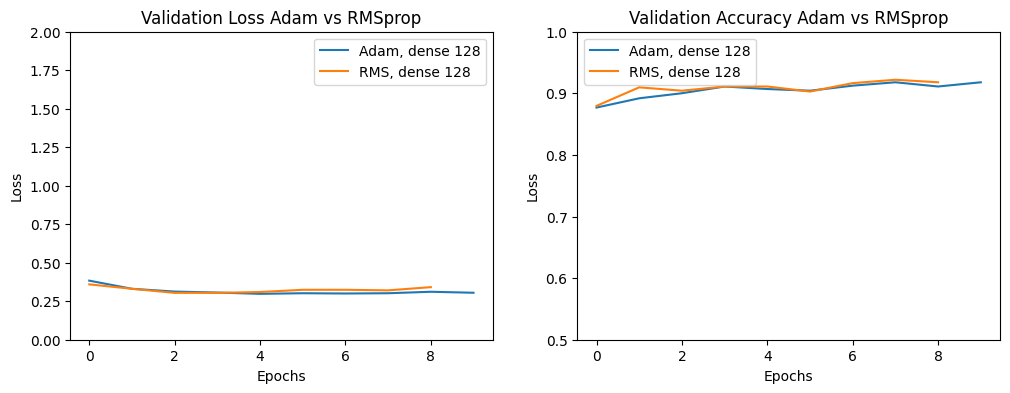

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(histories_Adam_dense[1].history['val_loss'], label='Adam, dense {}'.format(num_dense[1]))
plt.plot(histories_RMS_dense[1].history['val_loss'], label='RMS, dense {}'.format(num_dense[1]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Adam vs RMSprop')
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(histories_Adam_dense[1].history['val_accuracy'], label='Adam, dense {}'.format(num_dense[1]))
plt.plot(histories_RMS_dense[1].history['val_accuracy'], label='RMS, dense {}'.format(num_dense[1]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy Adam vs RMSprop')
plt.legend()


Now we can fix the number of dense nodes to 128

# Net with optimizer Adam and different augmentation
- learning rate = 0.001
- regularizer = 0.0001
- dense nodes = 128

In [35]:
def random_channel_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

new_data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.GaussianNoise(0.1),
        layers.Lambda(random_channel_flip),

    ]
)



resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in resnet_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = new_data_augmentation(x)
x = keras.applications.resnet.preprocess_input(x)
x = resnet_model(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_Adam_na = keras.Model(inputs=inputs, outputs=outputs)


from tensorflow.keras.optimizers import Adam
# Compile the model
net_Adam_na.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


net_Adam_na.summary()

# train the model
history_Adam_na = net_Adam_na.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

net_Adam_na.save('drive/MyDrive/FDL/resnet_Adam_na.h5')

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_20  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_20 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_20  (None, 2048)             0  

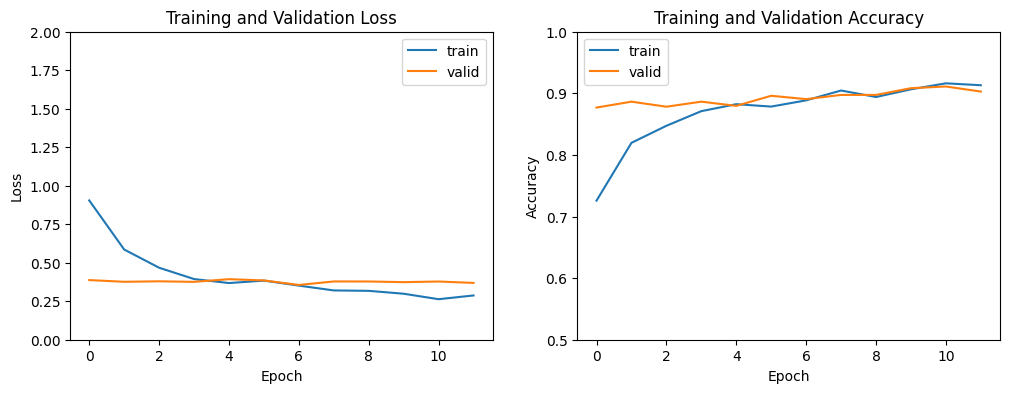

In [37]:
# Visualization of the learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Adam_na.history['loss'])
plt.plot(history_Adam_na.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Loss');

plt.subplot(1, 2, 2)
plt.plot(history_Adam_na.history['accuracy'])
plt.plot(history_Adam_na.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Accuracy');

In [38]:
loss, accuracy = net_Adam_na.evaluate(test_dataset)

12/12 [==============================] - 2s 106ms/step - loss: 0.3029 - accuracy: 0.9032


# Net with optimizer RMS and different augmentation
- learning rate = 0.001
- regularizer = 0.0001
- dense nodes = 128

In [39]:
def random_channel_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

new_data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.GaussianNoise(0.1),
        layers.Lambda(random_channel_flip),
    ]
)

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in resnet_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = new_data_augmentation(x)
x = keras.applications.resnet.preprocess_input(x)
x = resnet_model(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_RMS_na = keras.Model(inputs=inputs, outputs=outputs)



# Compile the model
net_RMS_na.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])


net_RMS_na.summary()

# train the model
history_RMS_na = net_RMS_na.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

net_RMS_na.save('drive/MyDrive/FDL/resnet_RMS_na.h5')

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_21  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_21 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_21  (None, 2048)             0  

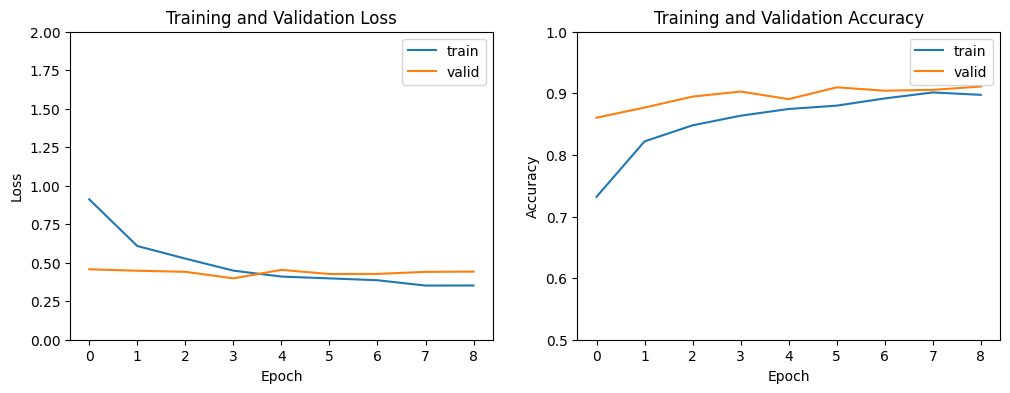

In [40]:
# Visualization of the learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_RMS_na.history['loss'])
plt.plot(history_RMS_na.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Loss');

plt.subplot(1, 2, 2)
plt.plot(history_RMS_na.history['accuracy'])
plt.plot(history_RMS_na.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title('Training and Validation Accuracy');

In [41]:
loss, accuracy = net_RMS_na.evaluate(test_dataset)

12/12 [==============================] - 2s 96ms/step - loss: 0.3130 - accuracy: 0.9140


# Adam vs RMS

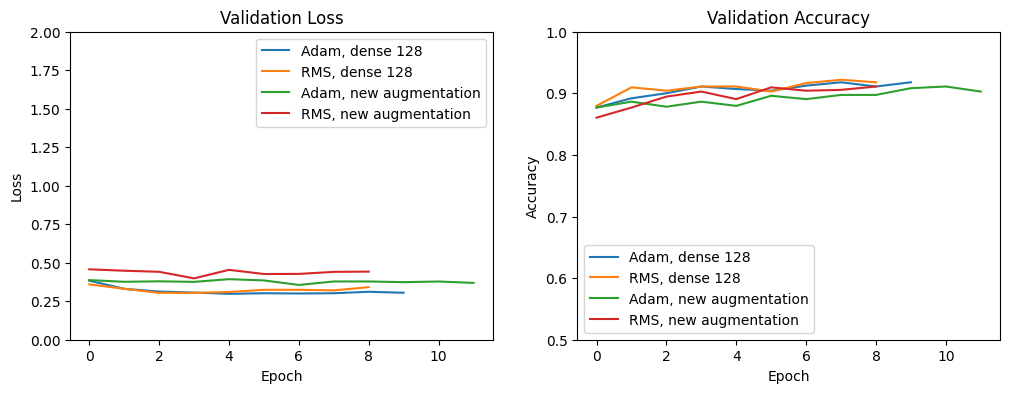

In [43]:
# Visualization of the learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(histories_Adam_dense[1].history['val_loss'], label='Adam, dense {}'.format(num_dense[1]))
plt.plot(histories_RMS_dense[1].history['val_loss'], label='RMS, dense {}'.format(num_dense[1]))
plt.plot(history_Adam_na.history['val_loss'], label='Adam, new augmentation')
plt.plot(history_RMS_na.history['val_loss'], label='RMS, new augmentation')
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss');

plt.subplot(1, 2, 2)
plt.plot(histories_Adam_dense[1].history['val_accuracy'], label='Adam, dense {}'.format(num_dense[1]))
plt.plot(histories_RMS_dense[1].history['val_accuracy'], label='RMS, dense {}'.format(num_dense[1]))
plt.plot(history_Adam_na.history['val_accuracy'], label='Adam, new augmentation')
plt.plot(history_RMS_na.history['val_accuracy'], label='RMS, new augmentation')
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy');

Best resnet model: optimizer: adam, number of dense nodes=128, lr=0.001, reg=0.0001, base augmentation